In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series
np.random.seed(20160614)
tf.set_random_seed(20160614)

In [8]:
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns=['x1','x2'])
    df['t'] = t
    return df
df0 = generate_datablock(15, [7,7], 22, 0)
df1 = generate_datablock(15, [22,7], 22, 0)
df2 = generate_datablock(10, [7,22], 22, 0)
df3 = generate_datablock(25, [20,20], 22, 1)
df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [9]:
train_x = train_set[['x1','x2']].as_matrix()
train_t = train_set['t'].as_matrix().reshape([len(train_set), 1])

num_units = 4 # number of units in the hidden layer
mult = train_x.flatten().mean()

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1*mult)
#hidden1 = tf.nn.relu(tf.matmul(x,w1) + b1*mult)


w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [10]:
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\tensorflow\python\client\session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [11]:
i = 0
for _ in range(1000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

Step: 100, Loss: 37.903206, Accuracy: 0.723077
Step: 200, Loss: 47.201328, Accuracy: 0.769231
Step: 300, Loss: 22.374586, Accuracy: 0.907692
Step: 400, Loss: 10.664211, Accuracy: 0.969231
Step: 500, Loss: 10.493211, Accuracy: 0.953846
Step: 600, Loss: 9.114985, Accuracy: 0.953846
Step: 700, Loss: 8.481773, Accuracy: 0.953846
Step: 800, Loss: 8.046441, Accuracy: 0.953846
Step: 900, Loss: 7.687421, Accuracy: 0.953846
Step: 1000, Loss: 7.444983, Accuracy: 0.953846


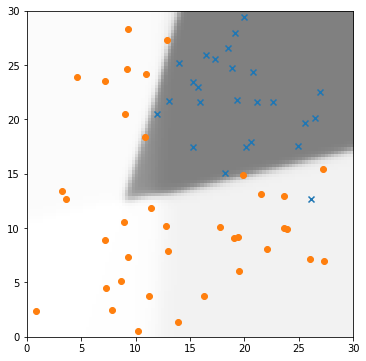

In [12]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
    for x1 in np.linspace(0,30,100):
        locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30),cmap=plt.cm.gray_r, alpha=0.5)

-----------------------------------------------------------------------------------

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
np.random.seed(20160612)
tf.set_random_seed(20160612)


In [6]:

#[MSL-02] MNIST data set를 준비한다.
def mnist_load():
      (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
      # Train set
      # Image
      train_x = train_x.reshape([train_x.shape[0], -1])
      train_x = train_x.astype('float32') / 255
      # Label
      train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)
      # Test set
      # Image
      test_x = test_x.reshape([test_x.shape[0], -1])
      test_x = test_x.astype('float32') / 255
      # Label
      test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)
      
      return (train_x, train_y), (test_x, test_y)

(train_x, train_y), (test_x, test_y) = mnist_load()
buffer_size = train_x.shape[0] + test_x.shape[0]
dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))
dataset = dataset.shuffle(buffer_size).repeat().batch(MINIBATCH_SIZE)
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()


#[MSL-03] 단층 Neural Networks를 이용한 확률 p의 계산식을 준비
num_units = 1024
x = tf.placeholder(tf.float32, [None, 784])
w1 = tf.Variable(tf.truncated_normal([784, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1)
w0 = tf.Variable(tf.zeros([num_units, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden1, w0) + b0)

#[MSL-04] 오차 함수 loss, Training 알고리즘 train_step, 정답률 accuracy를 정의
t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

mnist1




Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000026C55820D30>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000026C4EF86A90>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000026C4EF86BA8>)

In [4]:
#Optimization
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(2000):
    i += 1
    batch_xs, batch_ts = sess.run(next_batch)
    sess.run(train_step, feed_dict={x: batch_xs, t: batch_ts})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],feed_dict={x:mnist.test.images, t: mnist.test.labels})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

#Print
images, labels = mnist.test.images, mnist.test.labels
p_val = sess.run(p, feed_dict={x:images, t: labels})

fig = plt.figure(figsize=(8,15))
for i in range(10):
    c = 1
    for (image, label, pred) in zip(images, labels, p_val):
        prediction, actual = np.argmax(pred), np.argmax(label)
        if prediction != i:
            continue
        if (c < 4 and i == actual) or (c >= 4 and i != actual):
            subplot = fig.add_subplot(10,6,i*6+c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.set_title('%d / %d' % (prediction, actual))
            subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,cmap=plt.cm.gray_r, interpolation="nearest")
            c += 1
            if c > 6:
                break

AttributeError: 'tuple' object has no attribute 'train'

--------------------------------------------------------------------------------------------------

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series
np.random.seed(20160614)
tf.set_random_seed(20160614)

In [ ]:
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns=['x1','x2'])
    df['t'] = t
    return df

df0 = generate_datablock(30, [-7,-7], 18, 1)
df1 = generate_datablock(30, [-7,7], 18, 0)
df2 = generate_datablock(30, [7,-7], 18, 0)
df3 = generate_datablock(30, [7,7], 18, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [ ]:
train_x = train_set[['x1','x2']].as_matrix()
train_t = train_set['t'].as_matrix().reshape([len(train_set), 1])

num_units1 = 2 # first hidden layer
num_units2 = 2 # second hidden layer
x = tf.placeholder(tf.float32, [None, 2])
w1 = tf.Variable(tf.truncated_normal([2, num_units1]))
b1 = tf.Variable(tf.zeros([num_units1]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1)
w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(hidden1, w2) + b2)
w0 = tf.Variable(tf.zeros([num_units2, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden2, w0) + b0)

In [ ]:
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
i = 0
for _ in range(1000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

In [ ]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([-20,20])
subplot.set_xlim([-20,20])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
    for x1 in np.linspace(0,30,100):
        locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30),cmap=plt.cm.gray_r, alpha=0.5)